# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [04:32<00:00, 1337.17it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 116756)
the number of unique words  116756


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 5: Apply Logistic Regression

# Applying Logistic Regression

In [33]:
#import warnings
#warnings.simplefilter(action='ignore', category=Warning)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

final['cleaned_text']=preprocessed_reviews
final.sort_values(by='Time')
final1 = final.sample(n = 100000)

X=final1['cleaned_text'].values
Y=final1['Score'].values

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=13,shuffle=False)
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2,random_state=13,shuffle=False)

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [34]:
vectorizer=CountVectorizer()
vectorizer=vectorizer.fit(X_train)
X_train_bow=vectorizer.transform(X_train)
X_cv_bow=vectorizer.transform(X_cv)
X_test_bow=vectorizer.transform(X_test)
print('='*100)
print("After transform")
print(X_train_bow.shape,Y_train.shape)
print(X_cv_bow.shape,Y_cv.shape)
print(X_test_bow.shape,Y_cv.shape)

After transform
(80000, 54519) (80000,)
(20000, 54519) (20000,)
(20000, 54519) (20000,)


In [35]:
tuned_parameters = [{'C': [10**-2,10**-1, 10**0,10**1, 10**2]}]
model = GridSearchCV(LogisticRegression(penalty='l1'),tuned_parameters, scoring = 'roc_auc',cv=10,n_jobs=-1)
model.fit(X_train_bow, Y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [36]:
print(model.best_estimator_)
print(model.score(X_test_bow, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9380599542698284


100%|██████████| 8/8 [00:17<00:00,  3.08s/it]


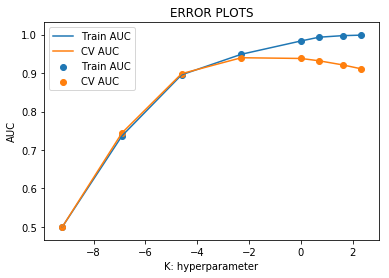

In [37]:
import math
from sklearn.metrics import roc_auc_score
train_auc = []
logc=[]
cv_auc = []
C=[0.0001,0.001,0.01,0.1,1,2,5,10]
#tuned_parameters = [{'C': list(np.arange(0.4,1,0.05))}]
for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l1')
    logit.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  logit.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc.append(math.log(i))

plt.plot(logc, train_auc, label='Train AUC')
plt.scatter(logc, train_auc, label='Train AUC')
plt.plot(logc, cv_auc, label='CV AUC')
plt.scatter(logc, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
C = list(np.arange(0.01,1,0.02))
cv_score = []
for k in tqdm(C):
    logit1 = LogisticRegression(C=k,penalty='l1')
    scores = cross_val_score(logit1, X_train_bow, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())                             

100%|██████████| 50/50 [16:00<00:00, 23.21s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  0.37
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.122 0.101 0.093 0.089 0.087 0.085 0.083 0.082 0.081 0.08  0.08  0.079
 0.079 0.079 0.078 0.078 0.078 0.078 0.078 0.078 0.078 0.078 0.078 0.078
 0.078 0.078 0.078 0.078 0.078 0.078 0.078 0.078 0.078 0.078 0.078 0.078
 0.078 0.078 0.078 0.079 0.079 0.079 0.079 0.079 0.079 0.079 0.079 0.079
 0.079 0.079]
_____________________________________________________________________________________________________


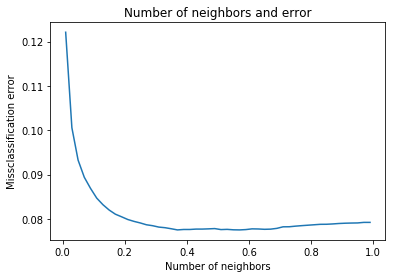

In [40]:
MSE = [1 - x for x in cv_score]
optimal_L1 = C[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", np.round(optimal_L1,2))
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)
optimal_L1=np.round(optimal_L1,2)
plt.plot(C, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [41]:
optimal_model = LogisticRegression(C=optimal_L1,penalty='l1')
optimal_model.fit(X_train_bow, Y_train)
prediction = optimal_model.predict(X_test_bow)

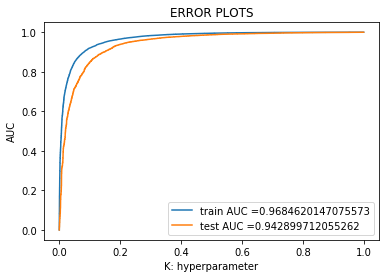

In [42]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_bow)[:,1])
AUC1=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [43]:
training_accuracy = optimal_model.score(X_train_bow, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.9395625
Train Error:  0.06043750000000003
Test Accuracy:  0.9232
Test Error:  0.07679999999999998
_____________________________________________________________________________________________________


Confusion Matrix for Train Data

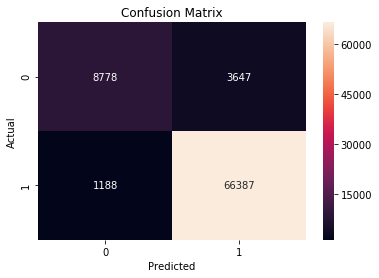

_____________________________________________________________________________________________________


In [44]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(X_train_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

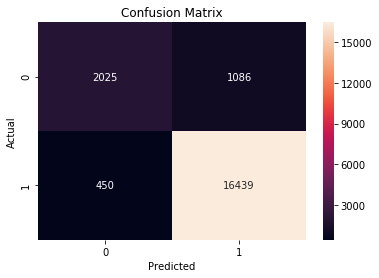

_____________________________________________________________________________________________________


In [45]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [46]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.82      0.65      0.73      3111
           1       0.94      0.97      0.96     16889

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.88      0.81      0.84     20000
weighted avg       0.92      0.92      0.92     20000



#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [47]:
clf = LogisticRegression(C=0.0001, penalty='l1');
clf.fit(X_train_bow, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

0


In [48]:
clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(X_train_bow, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

6


In [49]:
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(X_train_bow, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

163


In [50]:
clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(X_train_bow, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

1058


In [51]:
clf = LogisticRegression(C=0.41, penalty='l1');
clf.fit(X_train_bow, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

3064


In [52]:
clf = LogisticRegression(C=1, penalty='l1');
clf.fit(X_train_bow, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

5499


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [53]:
tuned_parameters = [{'C': [10**-2,10**-1, 10**0,10**1, 10**2]}]

In [166]:
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc',cv=10,n_jobs=-1)
model.fit(X_train_bow, Y_train)

print(model.best_estimator_)
print(model.score(X_test_bow, Y_test))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9437503129658267





  0%|          | 0/7 [00:00<?, ?it/s]


 14%|█▍        | 1/7 [00:01<00:06,  1.03s/it]


 29%|██▊       | 2/7 [00:02<00:05,  1.19s/it]


 43%|████▎     | 3/7 [00:05<00:07,  1.79s/it]


 57%|█████▋    | 4/7 [00:16<00:13,  4.55s/it]


 71%|███████▏  | 5/7 [00:41<00:21, 10.56s/it]


 86%|████████▌ | 6/7 [01:08<00:15, 15.66s/it]


100%|██████████| 7/7 [01:51<00:00, 23.63s/it]

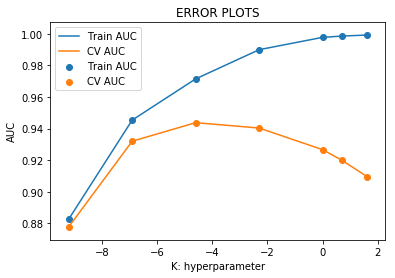

In [167]:
from sklearn.metrics import roc_auc_score
train_auc = []
logc1=[]
cv_auc = []
del C
C=[0.0001,0.001,0.01,0.1,1,2,5]
#tuned_parameters = [{'C': list(np.arange(0.4,1,0.05))}]
for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l2')
    logit.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  logit.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc1.append(math.log(i))

plt.plot(logc1, train_auc, label='Train AUC')
plt.scatter(logc1, train_auc, label='Train AUC')
plt.plot(logc1, cv_auc, label='CV AUC')
plt.scatter(logc1, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [168]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
C = list(np.arange(0.001,0.01,0.002))
cv_score = []
for k in tqdm(C):
    logit1 = LogisticRegression(C=k,penalty='l2')
    scores = cross_val_score(logit1, X_train_bow, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())                             




  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:16<01:07, 16.77s/it]


 40%|████      | 2/5 [00:40<00:56, 18.77s/it]


 60%|██████    | 3/5 [01:04<00:40, 20.37s/it]


 80%|████████  | 4/5 [01:39<00:24, 24.81s/it]


100%|██████████| 5/5 [02:09<00:00, 26.48s/it]

_____________________________________________________________________________________________________
Optimal number of neighbors:  0.009000000000000001
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.067 0.057 0.055 0.054 0.054]
_____________________________________________________________________________________________________


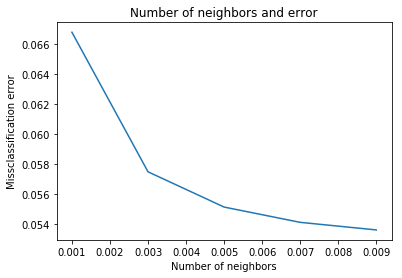

In [169]:
MSE = [1 - x for x in cv_score]
optimal_L2 = C[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_L2)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)
optimal_L2=np.round(optimal_L2,2)
plt.plot(C, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [170]:
optimal_model = LogisticRegression(C=optimal_L2,penalty='l2')
optimal_model.fit(X_train_bow, Y_train)
prediction = optimal_model.predict(X_test_bow)

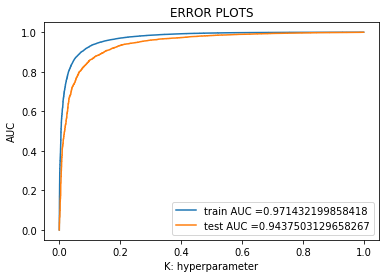

In [171]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_bow)[:,1])
AUC2=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [172]:
training_accuracy = optimal_model.score(X_train_bow, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.9405625
Train Error:  0.05943750000000003
Test Accuracy:  0.8868
Test Error:  0.11319999999999997
_____________________________________________________________________________________________________


Confusion Matrix for Train Data

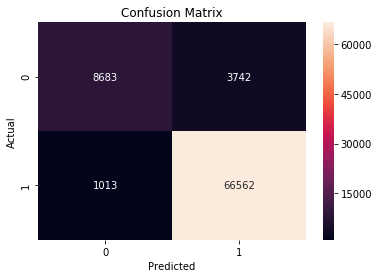

_____________________________________________________________________________________________________


In [173]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(X_train_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

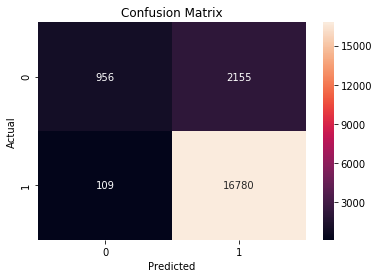

_____________________________________________________________________________________________________


In [174]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [175]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.90      0.31      0.46      3111
           1       0.89      0.99      0.94     16889

   micro avg       0.89      0.89      0.89     20000
   macro avg       0.89      0.65      0.70     20000
weighted avg       0.89      0.89      0.86     20000



#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [64]:
clf = LogisticRegression(C=optimal_L2, penalty='l2');
clf.fit(X_train_bow, Y_train);
w = clf.coef_
print(type(w),w.shape)
print(type(X_train_bow),X_train_bow.shape)
e=2
X_train_bow.data+=(e)
print(type(X_train_bow),X_train_bow.shape)

<class 'numpy.ndarray'> (1, 54519)
<class 'scipy.sparse.csr.csr_matrix'> (80000, 54519)
<class 'scipy.sparse.csr.csr_matrix'> (80000, 54519)


In [65]:
clf = LogisticRegression(C=optimal_L2, penalty='l2');
clf.fit(X_train_bow, Y_train);
w1 = clf.coef_
print(type(w1),w1.shape)

<class 'numpy.ndarray'> (1, 54519)


In [66]:
w=w+10**-6
w1=w1+10**-6
pchange=abs((w-w1)/w)*100

In [67]:
print(pchange.shape)
print(type(pchange))

(1, 54519)
<class 'numpy.ndarray'>


In [68]:
feature_names=vectorizer.get_feature_names()
print(type(feature_names))
print(feature_names[:5])

<class 'list'>
['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa']


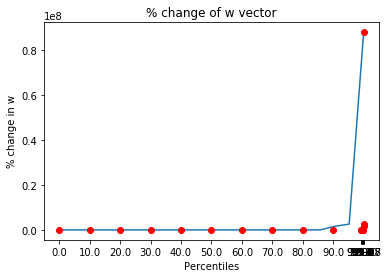

In [250]:
from matplotlib import mlab
p = np.array([0,10,20,30,40,50,60,70,80,90,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,99.997,99.998,100])
perc = mlab.prctile(pchange, p)
plt.plot(perc)
plt.plot((len(perc)-1) * p/100., perc, 'ro')
plt.xticks((len(perc)-1) * p/100., map(str, p))
plt.xlabel("Percentiles")
plt.ylabel("% change in w")
plt.title("% change of w vector")
plt.show()

<b>Observation:</b> Here we can see that the elbow point is at 99.9th percentile.

In [70]:
print(pchange.shape,type(pchange))
print(type(feature_names))

(1, 54519) <class 'numpy.ndarray'>
<class 'list'>


In [71]:
pchange_featues=pd.DataFrame(pchange,columns=feature_names)
pchange_featues=pchange_featues.T
pchange_featues.columns = ['pchange1']
print("99.9th percentile:")
pchange_featues.pchange1.quantile(0.999)

99.9th percentile:


14621.081939072545

<b> Collinear Features: </b>

In [72]:
collinear_features=pchange_featues[pchange_featues.pchange1 > int(pchange_featues.pchange1.quantile(0.999))]
coll_features=list(collinear_features.T.columns.values)
coll_features

['amaretto',
 'analgesic',
 'aromaticum',
 'arrhythmia',
 'attacks',
 'ave',
 'bergamont',
 'boasting',
 'burmannii',
 'cinnamaldehyde',
 'cinnamonum',
 'coumarins',
 'dances',
 'decomposing',
 'dept',
 'deserved',
 'dollop',
 'faintest',
 'genus',
 'gevalia',
 'ginormous',
 'guard',
 'hypers',
 'laying',
 'litter',
 'loureiroi',
 'lymphedema',
 'maltipoo',
 'marking',
 'merick',
 'mimics',
 'miscalculation',
 'misgivings',
 'nm',
 'parcel',
 'peddlers',
 'pittance',
 'pizzas',
 'pollux',
 'presription',
 'quill',
 'quills',
 'reps',
 'revisit',
 'ring',
 'salesmy',
 'suspicians',
 'swithced',
 'tradename',
 'triglcerides',
 'twitter',
 'unresolved',
 'wjla',
 'woodruff',
 'zombie']

<b> Observation:</b> It is observed that the above mentioned words(features) are collinear as with a slight change in w, percent change in them was found very high.

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [73]:
w=optimal_model.coef_
feature_names=vectorizer.get_feature_names()
print(feature_names[:5])
features2=pd.DataFrame(w,columns=([feature_names]))

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa']


In [74]:
features2=features2.T
features2.columns=['w']

In [75]:
features2=features2.sort_values(by=['w'],ascending=False)
#prob2=prob2.sort_values(by=["w"],ascending=False).head(10)

In [76]:
features2.head(10)

,w
delicious,1.520919
excellent,1.357430
wonderful,1.339214
perfect,1.335301
pleased,1.334546
best,1.219436
great,1.160619
amazing,1.155466
loves,1.155120
yummy,1.143572


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [77]:
features2=features2.sort_values(by=['w'],ascending=True)
#prob2=prob2.sort_values(by=["w"],ascending=False).head(10)

In [78]:
features2.head(10)

,w
disappointing,-1.961182
worst,-1.934911
terrible,-1.511785
disappointment,-1.369512
awful,-1.357207
disappointed,-1.334088
threw,-1.331944
bland,-1.299875
horrible,-1.290011
unfortunately,-1.192634


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [79]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
X_train_tfidf= tf_idf_vect.transform(X_train)
X_cv_tfidf=tf_idf_vect.transform(X_cv)
X_test_tfidf=tf_idf_vect.transform(X_test)

In [80]:
tuned_parameters = [{'C': [10**-2,10**-1, 10**0,10**1, 10**2]}]

In [238]:
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc',cv=10,n_jobs=-1)
model.fit(X_train_tfidf, Y_train)

print(model.best_estimator_)
print(model.score(X_test_tfidf, Y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9596356256525416


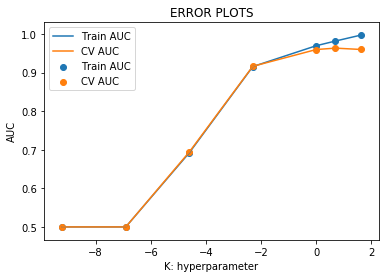

In [239]:
from sklearn.metrics import roc_auc_score
train_auc = []
logc1=[]
cv_auc = []
del C
C=[0.0001,0.001,0.01,0.1,1,2,5]
#tuned_parameters = [{'C': list(np.arange(0.4,1,0.05))}]
for i in C:
    logit = LogisticRegression(C=i,penalty='l1')
    logit.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  logit.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc1.append(math.log(i))

plt.plot(logc1, train_auc, label='Train AUC')
plt.scatter(logc1, train_auc, label='Train AUC')
plt.plot(logc1, cv_auc, label='CV AUC')
plt.scatter(logc1, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [240]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
C = list(np.arange(0.001,0.5,0.02))
cv_score = []
for k in C:
    logit1 = LogisticRegression(C=k,penalty='l2')
    scores = cross_val_score(logit1, X_train_tfidf, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())                             

_____________________________________________________________________________________________________
Optimal number of neighbors:  0.481
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.082 0.078 0.07  0.064 0.06  0.057 0.055 0.053 0.052 0.05  0.049 0.048
 0.047 0.046 0.046 0.045 0.044 0.044 0.043 0.043 0.043 0.042 0.042 0.042
 0.041]
_____________________________________________________________________________________________________


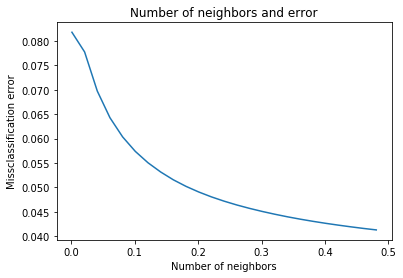

In [241]:
MSE = [1 - x for x in cv_score]
optimal_L3 = C[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", np.round(optimal_L3,3))
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)
optimal_L3=np.round(optimal_L3,3)
plt.plot(C, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [242]:
optimal_model = LogisticRegression(C=optimal_L3,penalty='l1')
optimal_model.fit(X_train_tfidf, Y_train)
prediction = optimal_model.predict(X_test_tfidf)

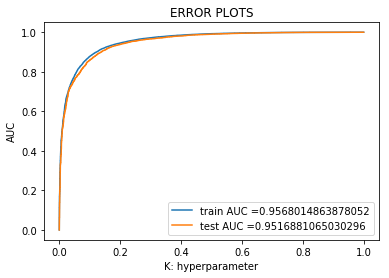

In [243]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_tfidf)[:,1])
AUC3=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [244]:
training_accuracy = optimal_model.score(X_train_tfidf, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.927075
Train Error:  0.07292500000000002
Test Accuracy:  0.9212
Test Error:  0.07879999999999998
_____________________________________________________________________________________________________


Confusion Matrix for Train Data

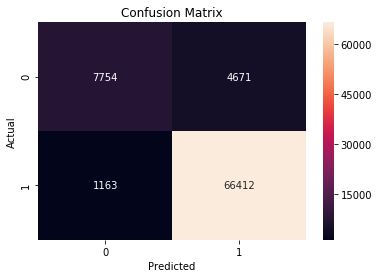

_____________________________________________________________________________________________________


In [245]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(X_train_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

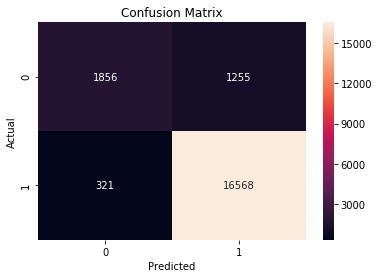

_____________________________________________________________________________________________________


In [246]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [247]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.85      0.60      0.70      3111
           1       0.93      0.98      0.95     16889

   micro avg       0.92      0.92      0.92     20000
   macro avg       0.89      0.79      0.83     20000
weighted avg       0.92      0.92      0.92     20000



### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [91]:
tuned_parameters = [{'C': [10**-2,10**-1, 10**0,10**1, 10**2]}]

In [186]:
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc',cv=10,n_jobs=-1)
model.fit(X_train_tfidf, Y_train)

print(model.best_estimator_)
print(model.score(X_test_tfidf, Y_test))

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9640036055947127


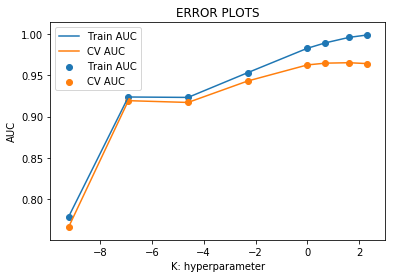

In [187]:
from sklearn.metrics import roc_auc_score
train_auc = []
logc1=[]
cv_auc = []
del C
C=[0.0001,0.001,0.01,0.1,1,2,5,10]
#tuned_parameters = [{'C': list(np.arange(0.4,1,0.05))}]
for i in C:
    logit = LogisticRegression(C=i,penalty='l2')
    logit.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  logit.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc1.append(math.log(i))

plt.plot(logc1, train_auc, label='Train AUC')
plt.scatter(logc1, train_auc, label='Train AUC')
plt.plot(logc1, cv_auc, label='CV AUC')
plt.scatter(logc1, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [188]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
C = list(np.arange(0.0001,0.1,0.02))
cv_score = []
for k in C:
    logit1 = LogisticRegression(C=k,penalty='l2')
    scores = cross_val_score(logit1, X_train_tfidf, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())                             

_____________________________________________________________________________________________________
Optimal number of neighbors:  0.08
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.239 0.078 0.07  0.064 0.06 ]
_____________________________________________________________________________________________________


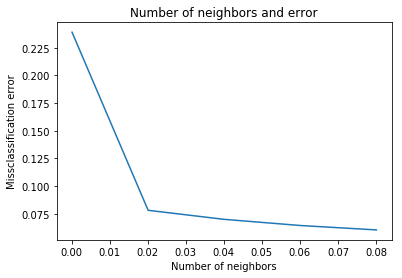

In [189]:
MSE = [1 - x for x in cv_score]
optimal_L4 = C[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", np.round(optimal_L4,3))
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)
optimal_L4=np.round(optimal_L4,3)
plt.plot(C, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [190]:
optimal_model = LogisticRegression(C=optimal_L4,penalty='l2')
optimal_model.fit(X_train_tfidf, Y_train)
prediction = optimal_model.predict(X_test_tfidf)

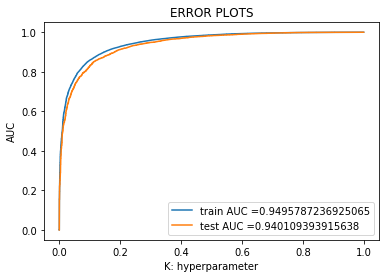

In [191]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_tfidf)[:,1])
AUC4=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [192]:
training_accuracy = optimal_model.score(X_train_tfidf, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8714125
Train Error:  0.12858749999999997
Test Accuracy:  0.87035
Test Error:  0.12965000000000004
_____________________________________________________________________________________________________


Confusion Matrix for Train Data

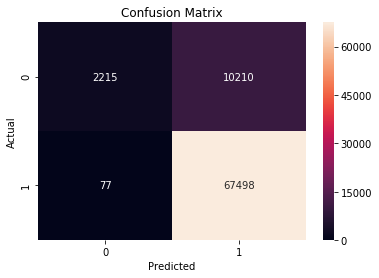

_____________________________________________________________________________________________________


In [193]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(X_train_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

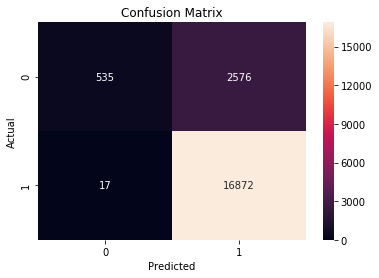

_____________________________________________________________________________________________________


In [194]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [195]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.97      0.17      0.29      3111
           1       0.87      1.00      0.93     16889

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.92      0.59      0.61     20000
weighted avg       0.88      0.87      0.83     20000



### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [102]:
w=optimal_model.coef_
feature_names=tf_idf_vect.get_feature_names()
print(feature_names[:5])
features2=pd.DataFrame(w,columns=([feature_names]))

['aa', 'aback', 'abandon', 'abandoned', 'abdominal']


In [103]:
features2=features2.T
features2.columns=['w']

In [104]:
features2=features2.sort_values(by=['w'],ascending=False)
#prob2=prob2.sort_values(by=["w"],ascending=False).head(10)

In [105]:
features2.head(10)

,w
great,12.000725
best,9.392919
delicious,9.076172
good,7.893171
perfect,7.449773
love,6.920817
wonderful,6.634525
excellent,6.524357
loves,6.427416
nice,5.672843


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [106]:
features2=features2.sort_values(by=['w'],ascending=True)
#prob2=prob2.sort_values(by=["w"],ascending=False).head(10)

In [107]:
features2.head(10)

,w
disappointed,-8.798308
not,-7.860875
worst,-7.388604
not worth,-6.953825
not good,-6.835857
disappointing,-6.817100
terrible,-6.493504
not recommend,-6.446945
awful,-6.129261
not buy,-6.032980


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [108]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17115
sample words  ['product', 'great', 'throw', 'diaper', 'bag', 'go', 'feedings', 'bought', 'amazon', 'read', 'reviews', 'purchased', 'cheaper', 'target', 'pack', 'plus', 'get', 'convenience', 'shipping', 'house', 'register', 'similac', 'website', 'send', 'used', 'store', 'bringing', 'total', 'instead', 'also', 'took', 'advice', 'another', 'poster', 'cheap', 'evenflo', 'bottles', 'reuse', 'nipples', 'definitely', 'suggestion', 'love', 'sugar', 'enough', 'write', 'review', 'shaker', 'even', 'though', 'already']


In [109]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 80000/80000 [06:05<00:00, 218.77it/s]


(80000, 50)
[ 0.09888204  1.59167001  0.07265039  0.34899947  0.20380483 -0.52164209
  0.18740749 -0.49472778 -0.50528123 -0.06863359 -0.54121819  0.11686058
  0.23448087  0.18293968 -0.27382703  0.12458233 -0.01896636  0.97992061
  0.37387846  0.09427837  0.00298634 -1.07432203  0.23525742  0.29002186
 -0.19435258  0.76226908 -0.00999723 -0.87559936 -0.25617322 -0.81544036
 -0.52323657  0.68208579 -0.272886    0.10091903 -0.31592077 -0.17310276
  0.40774093  0.71586528 -0.08435506 -0.23120683  1.11226404 -1.01950093
  0.0586948   0.08423591  0.53521627  0.03491916  1.06453518 -0.00695739
 -0.42038555 -0.12790915]


In [110]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 20000/20000 [01:34<00:00, 211.83it/s]


(20000, 50)
[ 0.14387024  0.23125865 -0.23919286  0.20109295  0.2102538   1.38575961
  0.28117265 -0.94583709  0.3092232  -0.17102826 -0.13161457 -0.77616384
  0.95320397 -0.68090548 -0.13673267 -0.0987211   0.5703871  -1.38168456
  0.33724416  0.0842342  -0.11860555 -0.64211611  0.41295706  0.51135241
  0.69083426  0.15548919  0.15304914 -0.40801144  0.3774057  -0.5466953
 -0.31093097 -0.27770969  0.74561904 -0.22876494  0.28954603 -1.18725826
  0.8687209  -0.89465052  0.1427362  -1.10615468 -0.58792231  0.0518748
 -0.48511787 -0.68723377 -0.35675649 -0.58818647  0.33623476  0.03861294
 -0.62828414 -0.71695532]


In [111]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 20000/20000 [01:31<00:00, 232.19it/s]

(20000, 50)
[ 0.14387024  0.23125865 -0.23919286  0.20109295  0.2102538   1.38575961
  0.28117265 -0.94583709  0.3092232  -0.17102826 -0.13161457 -0.77616384
  0.95320397 -0.68090548 -0.13673267 -0.0987211   0.5703871  -1.38168456
  0.33724416  0.0842342  -0.11860555 -0.64211611  0.41295706  0.51135241
  0.69083426  0.15548919  0.15304914 -0.40801144  0.3774057  -0.5466953
 -0.31093097 -0.27770969  0.74561904 -0.22876494  0.28954603 -1.18725826
  0.8687209  -0.89465052  0.1427362  -1.10615468 -0.58792231  0.0518748
 -0.48511787 -0.68723377 -0.35675649 -0.58818647  0.33623476  0.03861294
 -0.62828414 -0.71695532]


In [196]:
tuned_parameters = [{'C': [10**-2,10**-1, 10**0,10**1, 10**2]}]

In [197]:
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc',cv=10,n_jobs=-1)
model.fit(sent_vectors_train, Y_train)

print(model.best_estimator_)
print(model.score(sent_vectors_test, Y_test))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9052504964677661


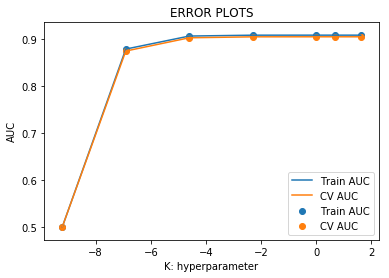

In [198]:
from sklearn.metrics import roc_auc_score
train_auc = []
logc1=[]
cv_auc = []
del C
C=[0.0001,0.001,0.01,0.1,1,2,5]
#tuned_parameters = [{'C': list(np.arange(0.4,1,0.05))}]
for i in C:
    logit = LogisticRegression(C=i,penalty='l1')
    logit.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  logit.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc1.append(math.log(i))

plt.plot(logc1, train_auc, label='Train AUC')
plt.scatter(logc1, train_auc, label='Train AUC')
plt.plot(logc1, cv_auc, label='CV AUC')
plt.scatter(logc1, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [199]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
C = list(np.arange(0.001,0.01,0.002))
cv_score = []
for k in C:
    logit1 = LogisticRegression(C=k,penalty='l1')
    scores = cross_val_score(logit1, sent_vectors_train, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())                             

_____________________________________________________________________________________________________
Optimal number of neighbors:  0.01
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.13 0.1  0.1  0.1  0.09]
_____________________________________________________________________________________________________


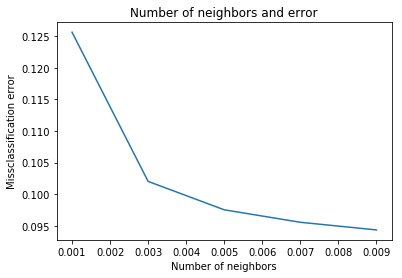

In [200]:
MSE = [1 - x for x in cv_score]
optimal_L5 = C[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", np.round(optimal_L5,2))
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 2))
print("_" * 101)
optimal_L5=np.round(optimal_L5,2)
plt.plot(C, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [201]:
optimal_model = LogisticRegression(C=optimal_L5,penalty='l1')
optimal_model.fit(sent_vectors_train, Y_train)
prediction = optimal_model.predict(sent_vectors_test)

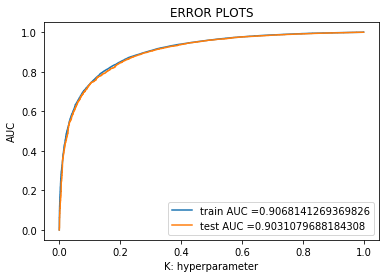

In [202]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(sent_vectors_test)[:,1])
AUC5=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [203]:
training_accuracy = optimal_model.score(sent_vectors_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8889625
Train Error:  0.11103750000000001
Test Accuracy:  0.88805
Test Error:  0.11195
_____________________________________________________________________________________________________


Confusion Matrix for Train Data

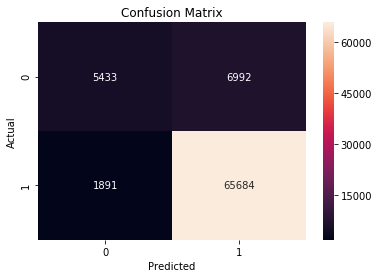

_____________________________________________________________________________________________________


In [204]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(sent_vectors_train))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

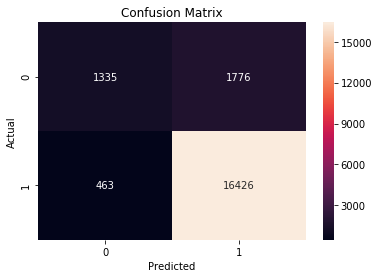

_____________________________________________________________________________________________________


In [205]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(sent_vectors_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [206]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.74      0.43      0.54      3111
           1       0.90      0.97      0.94     16889

   micro avg       0.89      0.89      0.89     20000
   macro avg       0.82      0.70      0.74     20000
weighted avg       0.88      0.89      0.88     20000



### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [123]:
tuned_parameters = [{'C': [10**-2,10**-1, 10**0,10**1, 10**2]}]

In [207]:
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc',cv=10,n_jobs=-1)
model.fit(sent_vectors_train, Y_train)

print(model.best_estimator_)
print(model.score(sent_vectors_test, Y_test))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9052319017060723





  0%|          | 0/7 [00:00<?, ?it/s]


 14%|█▍        | 1/7 [00:00<00:03,  1.87it/s]


 29%|██▊       | 2/7 [00:01<00:03,  1.60it/s]


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]


 57%|█████▋    | 4/7 [00:04<00:02,  1.01it/s]


 71%|███████▏  | 5/7 [00:05<00:02,  1.14s/it]


 86%|████████▌ | 6/7 [00:07<00:01,  1.25s/it]


100%|██████████| 7/7 [00:08<00:00,  1.32s/it]

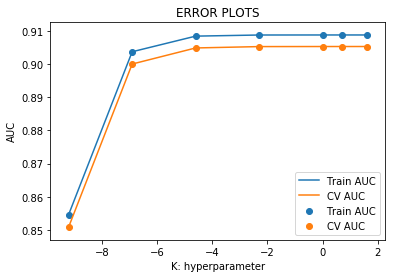

In [208]:
from sklearn.metrics import roc_auc_score
train_auc = []
logc1=[]
cv_auc = []
del C
C=[0.0001,0.001,0.01,0.1,1,2,5]
#tuned_parameters = [{'C': list(np.arange(0.4,1,0.05))}]
for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l2')
    logit.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  logit.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc1.append(math.log(i))

plt.plot(logc1, train_auc, label='Train AUC')
plt.scatter(logc1, train_auc, label='Train AUC')
plt.plot(logc1, cv_auc, label='CV AUC')
plt.scatter(logc1, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [209]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
C = list(np.arange(0.001,0.01,0.002))
cv_score = []
for k in tqdm(C):
    logit1 = LogisticRegression(C=k,penalty='l2')
    scores = cross_val_score(logit1, sent_vectors_train, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())                             




  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:08<00:34,  8.69s/it]


 40%|████      | 2/5 [00:17<00:26,  8.77s/it]


 60%|██████    | 3/5 [00:27<00:18,  9.00s/it]


 80%|████████  | 4/5 [00:38<00:09,  9.60s/it]


100%|██████████| 5/5 [00:49<00:00, 10.00s/it]

_____________________________________________________________________________________________________
Optimal number of neighbors:  0.01
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.1  0.09 0.09 0.09 0.09]
_____________________________________________________________________________________________________


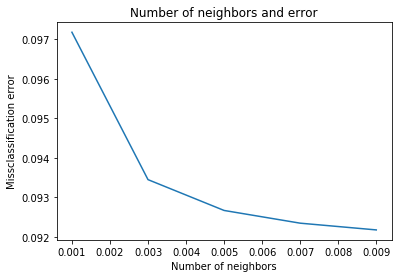

In [210]:
MSE = [1 - x for x in cv_score]
optimal_L6 = C[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", np.round(optimal_L6,2))
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 2))
print("_" * 101)
optimal_L6=np.round(optimal_L6,2)
plt.plot(C, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [211]:
optimal_model = LogisticRegression(C=optimal_L6,penalty='l2')
optimal_model.fit(sent_vectors_train, Y_train)
prediction = optimal_model.predict(sent_vectors_test)

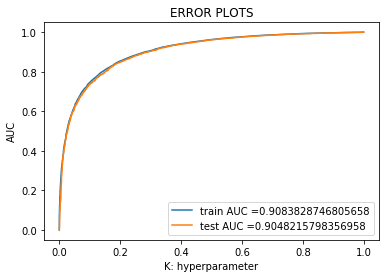

In [212]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(sent_vectors_test)[:,1])
AUC6=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [213]:
training_accuracy = optimal_model.score(sent_vectors_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.88975
Train Error:  0.11024999999999996
Test Accuracy:  0.8873
Test Error:  0.11270000000000002
_____________________________________________________________________________________________________


Confusion Matrix for Train Data

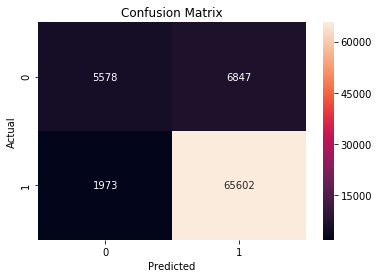

_____________________________________________________________________________________________________


In [214]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(sent_vectors_train))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

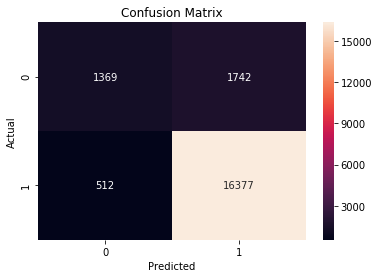

_____________________________________________________________________________________________________


In [215]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(sent_vectors_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [216]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.73      0.44      0.55      3111
           1       0.90      0.97      0.94     16889

   micro avg       0.89      0.89      0.89     20000
   macro avg       0.82      0.70      0.74     20000
weighted avg       0.88      0.89      0.88     20000



## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [135]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [136]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 80000/80000 [1:46:09<00:00, 12.56it/s]  


In [137]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [27:51<00:00, 11.97it/s] 


In [138]:
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [26:08<00:00, 14.14it/s] 


In [139]:
tuned_parameters = [{'C': [10**-2,10**-1, 10**0,10**1, 10**2]}]

In [217]:
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc',cv=10,n_jobs=-1)
model.fit(sent_vectors_train, Y_train)

print(model.best_estimator_)
print(model.score(sent_vectors_test, Y_test))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9052490499970509





  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:03,  2.08it/s]


 22%|██▏       | 2/9 [00:01<00:04,  1.41it/s]


 33%|███▎      | 3/9 [00:07<00:13,  2.23s/it]


 44%|████▍     | 4/9 [00:18<00:24,  4.85s/it]


 56%|█████▌    | 5/9 [00:29<00:26,  6.69s/it]


 67%|██████▋   | 6/9 [00:41<00:25,  8.40s/it]


 78%|███████▊  | 7/9 [00:51<00:17,  8.83s/it]


 89%|████████▉ | 8/9 [01:04<00:09,  9.89s/it]


100%|██████████| 9/9 [01:09<00:00,  8.64s/it]

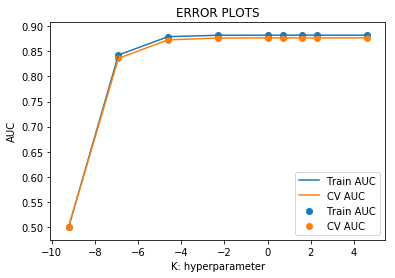

In [218]:
from sklearn.metrics import roc_auc_score
train_auc = []
logc1=[]
cv_auc = []
del C
C=[0.0001,0.001,0.01,0.1,1,2,5,10,100]
#tuned_parameters = [{'C': list(np.arange(0.4,1,0.05))}]
for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l1')
    logit.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  logit.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc1.append(math.log(i))

plt.plot(logc1, train_auc, label='Train AUC')
plt.scatter(logc1, train_auc, label='Train AUC')
plt.plot(logc1, cv_auc, label='CV AUC')
plt.scatter(logc1, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [219]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
C = list(np.arange(0.001,0.01,0.002))
cv_score = []
for k in tqdm(C):
    logit1 = LogisticRegression(C=k,penalty='l1')
    scores = cross_val_score(logit1, tfidf_sent_vectors_train, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())                             




  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:09<00:37,  9.32s/it]


 40%|████      | 2/5 [00:28<00:36, 12.21s/it]


 60%|██████    | 3/5 [00:52<00:31, 15.95s/it]


 80%|████████  | 4/5 [01:35<00:23, 23.96s/it]


100%|██████████| 5/5 [02:26<00:00, 31.96s/it]

_____________________________________________________________________________________________________
Optimal number of neighbors:  0.01
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.15 0.13 0.12 0.12 0.12]
_____________________________________________________________________________________________________


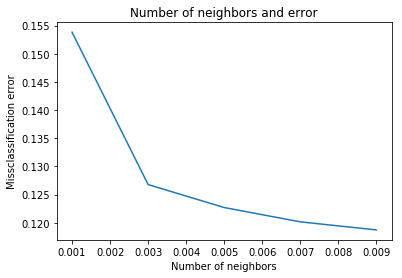

In [220]:
MSE = [1 - x for x in cv_score]
optimal_L7 = C[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", np.round(optimal_L7,2))
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 2))
print("_" * 101)
optimal_L7=np.round(optimal_L7,2)
plt.plot(C, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [221]:
optimal_model = LogisticRegression(C=optimal_L7,penalty='l1')
optimal_model.fit(tfidf_sent_vectors_train, Y_train)
prediction = optimal_model.predict(tfidf_sent_vectors_test)

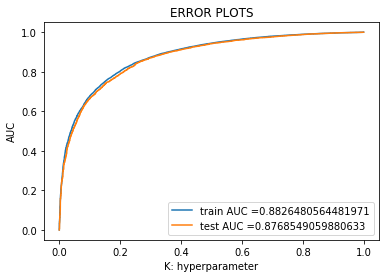

In [222]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(tfidf_sent_vectors_test)[:,1])
AUC7=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [223]:
training_accuracy = optimal_model.score(tfidf_sent_vectors_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8767
Train Error:  0.12329999999999997
Test Accuracy:  0.8731
Test Error:  0.1269
_____________________________________________________________________________________________________


Confusion Matrix for Train Data

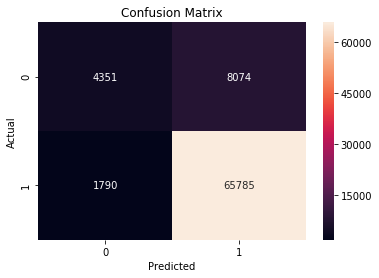

_____________________________________________________________________________________________________


In [224]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(tfidf_sent_vectors_train))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

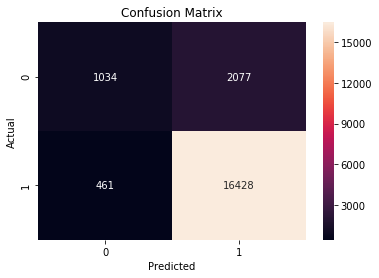

_____________________________________________________________________________________________________


In [225]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(tfidf_sent_vectors_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [226]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.69      0.33      0.45      3111
           1       0.89      0.97      0.93     16889

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.79      0.65      0.69     20000
weighted avg       0.86      0.87      0.85     20000



### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [152]:
tuned_parameters = [{'C': [10**-2,10**-1, 10**0,10**1, 10**2]}]

In [227]:
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc',cv=10,n_jobs=-1)
model.fit(sent_vectors_train, Y_train)

print(model.best_estimator_)
print(model.score(sent_vectors_test, Y_test))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9052319017060723





  0%|          | 0/7 [00:00<?, ?it/s]


 14%|█▍        | 1/7 [00:00<00:04,  1.41it/s]


 29%|██▊       | 2/7 [00:01<00:04,  1.24it/s]


 43%|████▎     | 3/7 [00:03<00:04,  1.02s/it]


 57%|█████▋    | 4/7 [00:05<00:03,  1.25s/it]


 71%|███████▏  | 5/7 [00:06<00:02,  1.43s/it]


 86%|████████▌ | 6/7 [00:08<00:01,  1.55s/it]


100%|██████████| 7/7 [00:10<00:00,  1.62s/it]

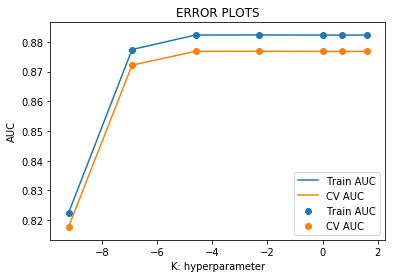

In [228]:
from sklearn.metrics import roc_auc_score
train_auc = []
logc1=[]
cv_auc = []
del C
C=[0.0001,0.001,0.01,0.1,1,2,5]
#tuned_parameters = [{'C': list(np.arange(0.4,1,0.05))}]
for i in tqdm(C):
    logit = LogisticRegression(C=i,penalty='l2')
    logit.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  logit.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  logit.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logc1.append(math.log(i))

plt.plot(logc1, train_auc, label='Train AUC')
plt.scatter(logc1, train_auc, label='Train AUC')
plt.plot(logc1, cv_auc, label='CV AUC')
plt.scatter(logc1, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [229]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
C = list(np.arange(0.001,0.01,0.002))
cv_score = []
for k in C:
    logit1 = LogisticRegression(C=k,penalty='l2')
    scores = cross_val_score(logit1, tfidf_sent_vectors_train, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())                             

_____________________________________________________________________________________________________
Optimal number of neighbors:  0.01
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.12 0.12 0.12 0.12 0.12]
_____________________________________________________________________________________________________


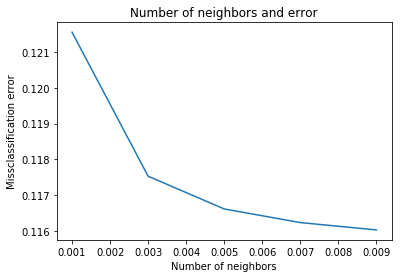

In [230]:
MSE = [1 - x for x in cv_score]
optimal_L8 = C[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", np.round(optimal_L8,2))
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 2))
print("_" * 101)
optimal_L8=np.round(optimal_L8,2)
plt.plot(C, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [231]:
optimal_model = LogisticRegression(C=optimal_L8,penalty='l2')
optimal_model.fit(tfidf_sent_vectors_train, Y_train)
prediction = optimal_model.predict(tfidf_sent_vectors_test)

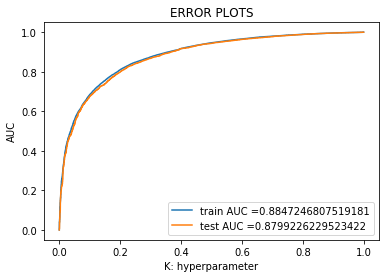

In [232]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(tfidf_sent_vectors_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [233]:
training_accuracy = optimal_model.score(tfidf_sent_vectors_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8775625
Train Error:  0.12243749999999998
Test Accuracy:  0.87465
Test Error:  0.12534999999999996
_____________________________________________________________________________________________________


Confusion Matrix for Train Data

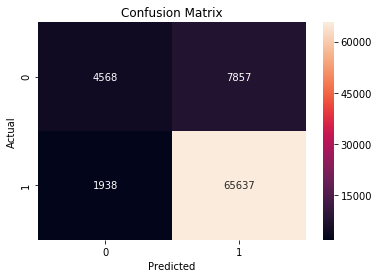

_____________________________________________________________________________________________________


In [234]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(tfidf_sent_vectors_train))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

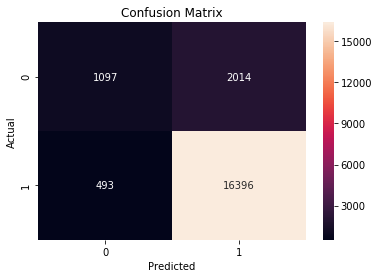

_____________________________________________________________________________________________________


In [235]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(tfidf_sent_vectors_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [236]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.69      0.35      0.47      3111
           1       0.89      0.97      0.93     16889

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.79      0.66      0.70     20000
weighted avg       0.86      0.87      0.86     20000



# [6] Conclusions

In [248]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
comparison = PrettyTable()
comparison.field_names = ["Vectorizer", "Regularization", "Hyperparameter", "AUC"]
comparison.add_row(["BOW", 'L1', optimal_L1, np.round(float(AUC1),4)])
comparison.add_row(["BOW", 'L2', optimal_L2, np.round(float(AUC2),4)])
comparison.add_row(["TFIDF", 'L1', optimal_L3, np.round(float(AUC3),4)])
comparison.add_row(["TFIDF", 'L2', optimal_L4,np.round(float(AUC4),4)])
comparison.add_row(["AVG W2V", 'L1', optimal_L5, np.round(float(AUC5),4)])
comparison.add_row(["AVG W2V", 'L2', optimal_L6, np.round(float(AUC6),4)])
comparison.add_row(["Weighted W2V", 'L1', optimal_L7, np.round(float(AUC7),4)])
comparison.add_row(["Weighted W2V", 'L2', optimal_L8, np.round(float(AUC8),4)])
print(comparison)


+--------------+----------------+----------------+--------+
|  Vectorizer  | Regularization | Hyperparameter |  AUC   |
+--------------+----------------+----------------+--------+
|     BOW      |       L1       |      0.37      | 0.9429 |
|     BOW      |       L2       |      0.01      | 0.9438 |
|    TFIDF     |       L1       |     0.481      | 0.9517 |
|    TFIDF     |       L2       |      0.08      | 0.9401 |
|   AVG W2V    |       L1       |      0.01      | 0.9031 |
|   AVG W2V    |       L2       |      0.01      | 0.9048 |
| Weighted W2V |       L1       |      0.01      | 0.8769 |
| Weighted W2V |       L2       |      0.01      | 0.8799 |
+--------------+----------------+----------------+--------+


<b><li>[1]. With reference to the Comparison Report above, C=0.48 by using TFIDF with L1 regularization followed by C=0.8 by using TFIDF with L2 regularization provides the best AUC and thus best performance. </li>
   <li>[2]. The Optimal C is to be chosen such that our model is not Overfit or Underfit. This can be done by simply following the below methods:</li>
    <li>-(i).  Split the dataset into TRAIN-CV-TEST with an appropriate ratio like 0.6:0.2:0.2</li>
    <li>-(ii). Plot the ROC_AUC curve of both, Train and CV data.</li>
    <li>-(iii).Now choose the a range for C such that the AUC of CV curve should be large and at the same time, should be closest to the TRAIN curve.</li>
    <li>-(iv). Selected C value should high AUC.</li> 
    <li>-(v). Small C value iincreases sparcity in L1 regularization.</li> 

    